In [1]:
import json
from pprint import pprint
from tqdm import tqdm
import re
import datetime as DT
import pandas as pd
import numpy as np
from prophet import Prophet
import seaborn as sns
import matplotlib.pyplot as plt
import os
import collections
import math

import pymorphy2
morph = pymorphy2.MorphAnalyzer()
parsed_file = '../data/huston/result.json'

In [2]:
# сохранение данных
def save_graph(datatype, path, filename):
    try:
        datatype.savefig(path + '/' + filename)
    except:
        os.mkdir(path)
        datatype.savefig(path + '/' + filename)

## Чтение данных и запись основной информации

In [3]:
with open('../data/stopwords.json', 'r', encoding='utf-8') as f:
    stopwords = json.load(f)

class user_info():
#   инициализация с присвоением имени
    def __init__(self, name):
        self.name = name

#   заполнение информации по сообщениям, стикерам, видео/аудио сообщениям и тд
    def create_info(self, history):
        self.ind = []
        self.tg_media_types = {
            'sticker': 0, 
            'video_file': 0, 
            'video_message': 0, 
            'voice_message': 0}

        self.count_messages = 0
        self.messages = []
        for i in tqdm(range(len(history['messages']))):
            if history['messages'][i]['type'] == 'message':
                if self.name == history['messages'][i]['from']:
                    try:
                        self.tg_media_types[history['messages'][i]['media_type']] += 1
                    except:
                        pass
                    self.messages.append(history['messages'][i]['text'])
                    self.count_messages += 1
    
#   оставляем только буквы, далее приводим все к нижнему регистру, разделяем на слова, лемматизируем и удаляем стоп слова
    def remove_stop_words(self):
        self.words_dict = {}
        self.corpus = []

        for i in range(len(self.messages)):
            self.corpus.append([])
            if type(self.messages[i]) is str:
                mess = re.sub("[^А-Яа-я]", " ", self.messages[i]).lower().split()
                new_mess = []
                for word in mess:
                    p = morph.parse(word)[0]
                    norm_word = p.normal_form
                    if word not in stopwords and norm_word not in stopwords:
                        new_mess.append(norm_word)
                        self.corpus[i].append(norm_word)
                        
                        if norm_word in self.words_dict.keys():
                            self.words_dict[norm_word] += 1
                        else:
                            self.words_dict[norm_word] = 1
                self.messages[i] = new_mess

        self.messages = list(filter(([]).__ne__, self.messages))
    
#   подсчитываем самые частые слова
    def sort_words_dict(self):
        sorted_dict = {}
        sorted_keys = sorted(self.words_dict, key=self.words_dict.get, reverse=True)

        for w in sorted_keys:
            sorted_dict[w] = self.words_dict[w]
        
        self.words_dict = sorted_dict


In [4]:
# считываем данные
with open(parsed_file, 'r', encoding='utf-8') as f:
    history = json.load(f)

date_info = {}
users = []

In [5]:
# первичная обработка данных, считываем юзеров и кол-во сообщений по датам
for i in tqdm(range(len(history['messages']))):
    date = history['messages'][i]['date'][:10]
    if date in date_info.keys():
        date_info[date] += 1
    else:
        date_info[date] = 1
    if history['messages'][i]['type'] == 'message':
        users.append(history['messages'][i]['from'])

100%|██████████| 87289/87289 [00:00<00:00, 778439.84it/s]


In [6]:
# проверяем имена юзеров
try:
    name_list = list(set(users))
    name1 = name_list[0]
    name2 = name_list[1]
except:
    pprint('Переписка должна быть между двумя людьми')

In [7]:
# создаем для каждого юзера экземпляр класса
user1 = user_info(name1)
user2 = user_info(name2)

In [8]:
# получаем информацию о каждом пользователе
user1.create_info(history)
user2.create_info(history)

100%|██████████| 87289/87289 [00:00<00:00, 1095593.29it/s]


## Лемматизация, удаление стоп слов и анализ самых популяных

In [9]:
# удаление стоп слов (после обработки текста)
user1.remove_stop_words()
user2.remove_stop_words()

In [10]:
# сортируем словарь слов по частосте появления
user1.sort_words_dict()
user2.sort_words_dict()

## Построение prophet модели (временные ряды)

In [11]:
# указываем праздники
ny = pd.DataFrame({'holiday': "New Year", 'ds' : pd.to_datetime(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04', 
                                                                 '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
                                                                 '2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04', 
                                                                 '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
                                                                 '2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04', 
                                                                 '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
                                                                 '2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04', 
                                                                 '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
                                                                 '2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04', 
                                                                 '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
                                                                 '2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04', 
                                                                 '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
                                                                 '2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04', 
                                                                 '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08'])})

dfd = pd.DataFrame({'holiday': "Defender of the Fatherland Day", 'ds' : pd.to_datetime(['2016-02-23', '2015-02-23', 
                                                                                        '2018-02-23', '2019-02-23', 
                                                                                        '2020-02-23', '2021-02-23', 
                                                                                        '2022-02-23'])})

iwd = pd.DataFrame({'holiday': "International Women's Day", 'ds' : pd.to_datetime(['2016-03-08', '2017-03-08',
                                                                                   '2018-03-08', '2019-03-08', 
                                                                                   '2020-03-08', '2021-03-08', 
                                                                                   '2022-03-08'])})

ld = pd.DataFrame({'holiday': "Labour Day", 'ds' : pd.to_datetime(['2016-05-01', '2017-05-01', '2018-05-01', '2019-05-01', 
                                                                   '2020-05-01', '2021-05-01', '2022-05-01'])})

vd = pd.DataFrame({'holiday': "Victory Day", 'ds' : pd.to_datetime(['2016-05-09', '2017-05-09', '2018-05-09', '2019-05-09', 
                                                                    '2020-05-09', '2021-05-09', '2022-05-09'])})

rd = pd.DataFrame({'holiday': "Russia Day", 'ds' : pd.to_datetime(['2016-06-12', '2017-06-12', '2018-06-12', '2019-06-12', 
                                                                   '2020-06-12', '2021-06-12', '2022-06-12'])})

ud = pd.DataFrame({'holiday': "Unity Day", 'ds' : pd.to_datetime(['2016-11-04', '2017-11-04', '2018-11-04', '2019-11-04', 
                                                                  '2020-11-04', '2021-11-04', '2022-11-04'])})

ru_holidays = pd.concat([ny, dfd, iwd, ld, vd, rd, ud])

In [12]:
# функция для удаления любых отрицательных прогнозных значений 
def remove_negs(ts):
    ts['yhat'] = ts['yhat'].clip(lower=0)
    ts['yhat_lower'] = ts['yhat_lower'].clip(lower=0)
    ts['yhat_upper'] = ts['yhat_upper'].clip(lower=0)

In [13]:
# создание списка дат по дням, начиная с самой ранней и заканчивая последней (нужно для того,
# чтобы не получились пропуски в датах, если в этот день переписки не было)
def create_dates_list(start_date, end_date):
    res = pd.date_range(min(start_date, end_date), max(start_date, end_date)).strftime('%Y-%m-%d').tolist()
    return(res)

# создание датасета для предикта
def create_pd_dataset(date_list, date_info):
    count_mess_list = []
    for i in range(len(date_list)):
        if date_list[i] in date_info.keys():
            count_mess_list.append(date_info[date_list[i]])
        else:
            count_mess_list.append(0)
    
    df_dict = {'ds': date_list, 'y': count_mess_list} 
    return(pd.DataFrame(df_dict))

In [14]:
min_date = min(date_info.keys())
max_date = max(date_info.keys())

start_df_date = DT.datetime(int(min_date[:4]), int(min_date[5:7]), int(min_date[8:10]))
end_df_date = DT.datetime(int(max_date[:4]), int(max_date[5:7]), int(max_date[8:10]))

date_list = create_dates_list(start_df_date, end_df_date)
df_pred = create_pd_dataset(date_list, date_info)

In [15]:
# создаем модель
m = Prophet(yearly_seasonality=True, holidays=ru_holidays, daily_seasonality=True)
m.fit(df_pred)
# прогноз + график
# указываем, на какой период хотим получить предсказание (в днях)
days = 365
future = m.make_future_dataframe(periods=days)
forecast = m.predict(future)
# 'yhat' - прогнозируемое значение, 'yhat_lower' и 'yhat_upper' - интервалы неопределенности
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Defender of the Fatherland Day,Defender of the Fatherland Day_lower,Defender of the Fatherland Day_upper,International Women's Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-06-08,10.746525,-58.544428,51.995211,10.746525,10.746525,0.0,0.0,0.0,0.0,...,5.451437,5.451437,5.451437,-10.376047,-10.376047,-10.376047,0.0,0.0,0.0,-3.174906
1,2017-06-09,10.801817,-64.867255,51.414940,10.801817,10.801817,0.0,0.0,0.0,0.0,...,2.554884,2.554884,2.554884,-10.040620,-10.040620,-10.040620,0.0,0.0,0.0,-5.680740
2,2017-06-10,10.857108,-77.050001,35.637775,10.857108,10.857108,0.0,0.0,0.0,0.0,...,-10.697550,-10.697550,-10.697550,-9.564550,-9.564550,-9.564550,0.0,0.0,0.0,-18.401812
3,2017-06-11,10.912400,-77.602805,42.928371,10.912400,10.912400,0.0,0.0,0.0,0.0,...,-12.475422,-12.475422,-12.475422,-8.963639,-8.963639,-8.963639,0.0,0.0,0.0,-19.523481
4,2017-06-12,10.967691,-66.034639,47.232690,10.967691,10.967691,0.0,0.0,0.0,0.0,...,4.522600,4.522600,4.522600,-8.257421,-8.257421,-8.257421,0.0,0.0,0.0,-10.319519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2113,2023-03-22,101.637915,53.281072,168.029082,99.503558,103.816463,0.0,0.0,0.0,0.0,...,5.115230,5.115230,5.115230,10.942683,10.942683,10.942683,0.0,0.0,0.0,108.699007
2114,2023-03-23,101.662699,48.847198,166.395882,99.520364,103.852705,0.0,0.0,0.0,0.0,...,5.451437,5.451437,5.451437,9.766307,9.766307,9.766307,0.0,0.0,0.0,107.883623
2115,2023-03-24,101.687483,48.859902,163.219838,99.537169,103.890108,0.0,0.0,0.0,0.0,...,2.554884,2.554884,2.554884,8.598015,8.598015,8.598015,0.0,0.0,0.0,103.843563
2116,2023-03-25,101.712268,32.197348,146.389435,99.553974,103.925320,0.0,0.0,0.0,0.0,...,-10.697550,-10.697550,-10.697550,7.454651,7.454651,7.454651,0.0,0.0,0.0,89.472549


In [16]:
# удаляем отрицательный прогноз
remove_negs(forecast)
forecast['yhat']

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
           ...    
2113    108.699007
2114    107.883623
2115    103.843563
2116     89.472549
2117     86.616003
Name: yhat, Length: 2118, dtype: float64

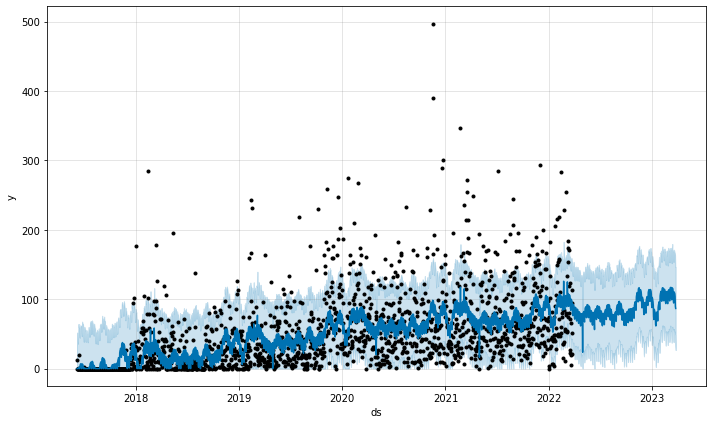

In [17]:
# строим график предсказания
fig = m.plot(forecast)
save_graph(fig, '../result/' + user1.name + '_' + user2.name, 'prophet_prediction.png')

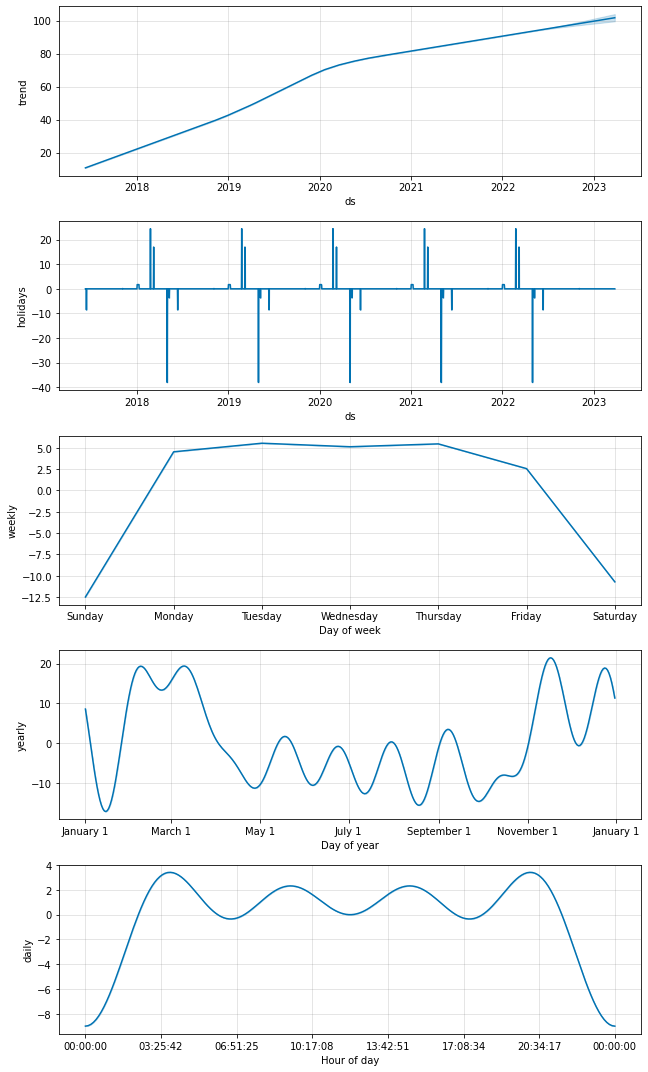

In [18]:
# получаем информацию о данных (например, частоту общения от дня недели)
fig = m.plot_components(forecast)
save_graph(fig, '../result/' + user1.name + '_' + user2.name, 'prophet_statistics_info.png')

## Построение графиков

## Кол-во сообщений в месяц

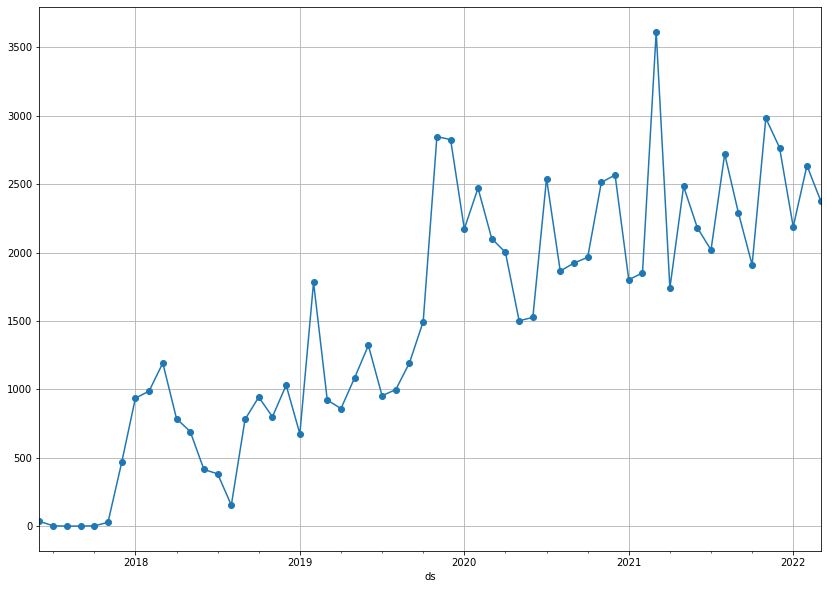

In [19]:
# строим график по кол-ву сообщений в месяц
df_graph = create_pd_dataset(date_list, date_info)
df_graph["ds"] = pd.to_datetime(df_graph['ds'])
df_graph.set_index('ds').resample('M')['y'].sum().plot(x='ds', y='y', rot=0, figsize=(14, 10), grid=True, marker='o')

save_graph(plt, '../result/' + user1.name + '_' + user2.name, 'statistics_of_messages.png')
plt.show()

## Кто сколько сообщений написал

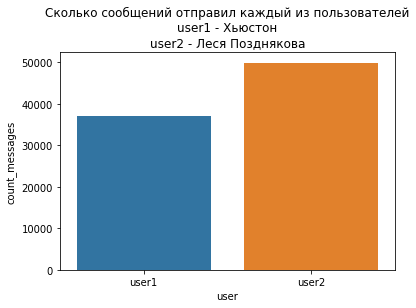

In [20]:
# строим график по числу сообщений
title = 'Сколько сообщений отправил каждый из пользователей\nuser1 - ' + user1.name + '\nuser2 - ' + user2.name
df_graph_dict = {
    'user': ['user1', 'user2'],
    'count_messages': [user1.count_messages, user2.count_messages]
}

df_graph = pd.DataFrame(df_graph_dict)
figure = sns.barplot(data=df_graph, x="user", y="count_messages").set_title(title)
fig = figure.get_figure()
save_graph(fig, '../result/' + user1.name + '_' + user2.name, 'number_of_messages.png')

## Самые частые слова

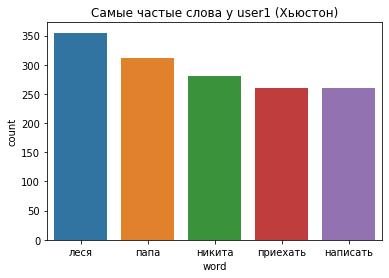

In [21]:
# график по самым частым словам юзера 1 (без учета стоп слов)
title = 'Самые частые слова у user1 (' + user1.name + ')'
if len(user1.words_dict) > 5:
    word_list = []
    count_list = []
    keys = list(user1.words_dict.keys())
    for i in range(5):
        word_list.append(keys[i])
        count_list.append(user1.words_dict[keys[i]])
    df_graph_dict = {
        'word': word_list,
        'count': count_list
    }
    df_graph = pd.DataFrame(df_graph_dict)
    figure = sns.barplot(data=df_graph, x="word", y="count").set_title(title)
    fig = figure.get_figure()
    save_graph(fig, '../result/' + user1.name + '_' + user2.name, 'top_words_(' + user1.name + ').png')

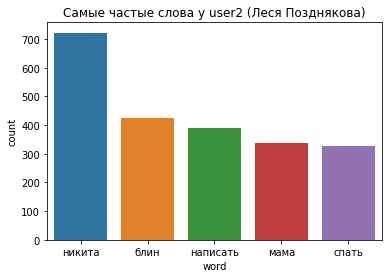

In [22]:
# график по самым частым словам юзера 2 (без учета стоп слов)
title = 'Самые частые слова у user2 (' + user2.name + ')'
if len(user2.words_dict) > 5:
    word_list = []
    count_list = []
    keys = list(user2.words_dict.keys())
    for i in range(5):
        word_list.append(keys[i])
        count_list.append(user2.words_dict[keys[i]])
    df_graph_dict = {
        'word': word_list,
        'count': count_list
    }
    df_graph = pd.DataFrame(df_graph_dict)
    figure = sns.barplot(data=df_graph, x="word", y="count").set_title(title)
    fig = figure.get_figure()
    save_graph(fig, '../result/' + user1.name + '_' + user2.name, 'top_words_(' + user2.name + ').png')

## Реализация массива TF_IDF показателей для каждого пользователя

In [23]:
from collections import Counter
# расчет tf
def compute_tf(text):
    tf_text = Counter(text)
    for i in tf_text:
        tf_text[i] = tf_text[i]/float(len(text))
    return tf_text

# расчет idf
def compute_idf(word, corpus):
    return math.log10(len(corpus)/sum([1.0 for i in corpus if word in i]))

# расчет tf-idf и запись в файл
def create_tf_idf(corpus, path, filename):
    documents_list = []
    corpus = user1.corpus
    for text in tqdm(corpus):
        tf_idf_dictionary = {}
        computed_tf = compute_tf(text)

        for word in computed_tf:
            tf_idf_dictionary[word] = computed_tf[word] * compute_idf(word, corpus)
        documents_list.append(tf_idf_dictionary)
    try:
        with open(path + '/' + filename, 'w') as fw:
            json.dump(documents_list, fw)
    except:
        os.mkdir(path)
        with open(path + '/' + filename, 'w') as fw:
            json.dump(documents_list, fw)

In [26]:
corpus = user1.corpus
create_tf_idf(corpus, '../result/' + user1.name + '_' + user2.name, 'tf-df_for_user1(' + str(user1.name) + ').txt')
corpus = user2.corpus
create_tf_idf(corpus, '../result/' + user1.name + '_' + user2.name, 'tf-df_for_user2(' + str(user2.name) + ').txt')

## Стикеры, голосовые, видео-сообщения

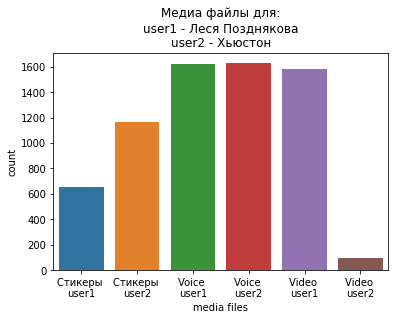

In [25]:
# график по медиа файлам, для удобства одинаковые типы выводятся рядом
title = 'Медиа файлы для:\nuser1 - ' + user1.name + '\nuser2 - ' + user2.name
df_graph_dict = {
    'media files': [
                    'Стикеры \nuser1', 'Стикеры \nuser2', 
                    'Voice \nuser1', 'Voice \nuser2',
                    'Video \nuser1', 'Video \nuser2'
                   ],
    'count': [
              user1.tg_media_types['sticker'], user2.tg_media_types['sticker'], 
              user1.tg_media_types['voice_message'], user2.tg_media_types['voice_message'], 
              user1.tg_media_types['video_message'], user2.tg_media_types['video_message']
             ]
}

df_graph = pd.DataFrame(df_graph_dict)
figure = sns.barplot(data=df_graph, x="media files", y="count", capsize = 0.1).set_title(title)
fig = figure.get_figure()
save_graph(fig, '../result/' + user1.name + '_' + user2.name, 'media_files_statistics.png')